In [1]:
import kmodels as kmk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_pickle('../data/FormattedData_wPainAndOA.pkl')
df.columns

Index(['Fx', 'Fy', 'Fz', 'FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP',
       'FPB', 'Subject', 'Event', 'Frame', 'Pain_Cohort', 'Eaton_Litter'],
      dtype='object')

In [3]:

def get_data_by_subject_and_event(df):
    groups = df.groupby(['Subject', 'Event'])
    Y = []
    X = []
    subject = []
    for name, group in groups:
        x_cols = ['Fx', 'Fy', 'Fz', 'FPL', 'APL', 'EPL', 'EPB', 'DIO', 'ADP', 'OPP', 'FPB', 'Frame']
        X.append(group[x_cols].to_numpy().reshape(1, -1))
        pain_mean = group['Pain_Cohort'].mean()
        Eaton_mean = group['Eaton_Litter'].mean()
        Y.append(np.array([pain_mean, Eaton_mean]).reshape(1, -1))
        subject.append(name[0])
    return np.vstack(X), np.vstack(Y), np.array(subject)

scaler = MinMaxScaler()
X, Y, subjects = get_data_by_subject_and_event(df)
subjects = pd.get_dummies(subjects).to_numpy()
X = np.hstack((X, subjects))
X = scaler.fit_transform(X)
X.shape, Y.shape, subjects

((30, 12010),
 (30, 2),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0

(array([ 6.,  0.,  0.,  6.,  0.,  0., 12.,  0.,  0.,  6.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

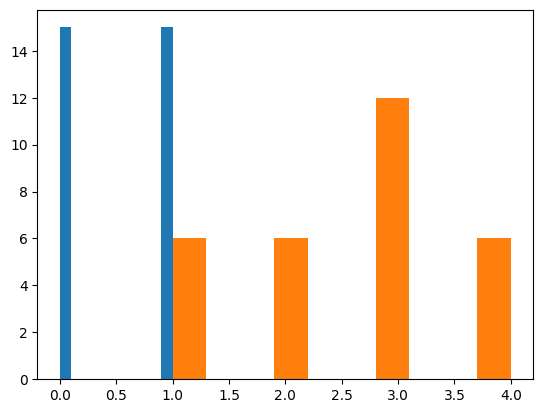

In [4]:
plt.hist(Y[:,0])
plt.hist(Y[:,1])

In [5]:
config = {
    'estimator_type': 'VAE',
    'input_dim': X.shape[1],
    'is_VAE': True,
    'batch_size':int(len(X)/10), 
    'epochs':21, 
    'verbose':10,
    'latent_dim': 2,
    'lr_init':5e-4,
    'n_layers':3,
}
reg = kmk.Trainer(**config)

In [6]:
def to_torch(X):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X.astype(np.float32))
    elif isinstance(X, pd.DataFrame):
        X = X.values
        X = torch.from_numpy(X.astype(np.float32))
    return X
X = to_torch(X)
Y = to_torch(Y)
reg.fit(X, X)

====> Epoch: 0 Average loss: 11325.800781250 Time: 2.92
Loss components: {}
====> Epoch: 10 Average loss: 2010.477172852 Time: 1.26
Loss components: {}
====> Epoch: 20 Average loss: 1855.708007812 Time: 1.29
Loss components: {}


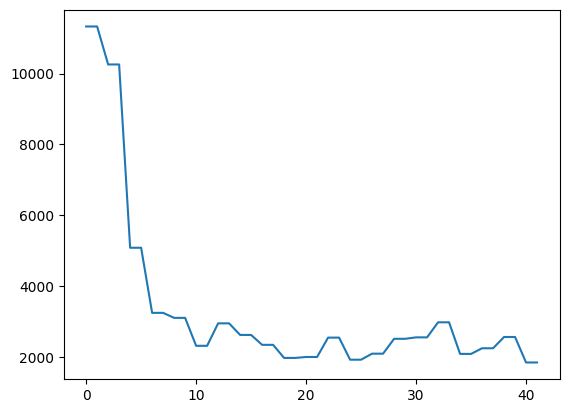

In [7]:
plt.plot(reg.losses)

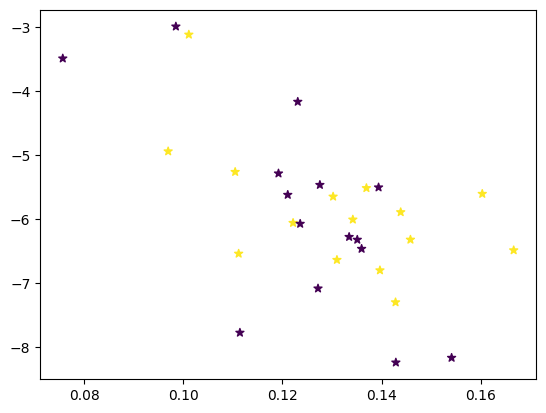

In [8]:
# get the encoded latent space and plot
X_encoded = reg.estimator.encode(X)[0].detach().numpy()
plt.scatter(X_encoded[:,0], X_encoded[:,1], c=Y[:,0], marker='*')

In [9]:
import plotly.express as px
# cmap is red to blue
# encoded_df 
Edf = pd.DataFrame(X_encoded[:, 0:2], columns=['x1', 'x2'])
Edf['Pain_Cohort'] = Y[:,0]
Edf['Eaton_Litter'] = Y[:,1]
# make the pain cohort categorical
Edf['Pain_Cohort'] = Edf['Pain_Cohort'].astype('category')
# now make the pain 1 category * and 0 category o
#Edf['Pain_Cohort'] = Edf['Pain_Cohort'].apply(lambda x: '*' if x == 1 else 'o')
fig = px.scatter(Edf, x='x1', y='x2', color='Eaton_Litter', symbol='Pain_Cohort', hover_data=['Eaton_Litter'])
# make the size of the pain cohort bigger
# fig.update_traces(marker=dict(size=12,
#                                 line=dict(width=2,
#                                             color='DarkSlateGrey')),
#                     selector=dict(mode='markers', symbol='*')) 
# # make the markers bigger with nicer backgrounds
fig.update_traces(marker=dict(size=12,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
# we want to really emphasize the Pain Cohort == 1 group. lets make the marker size much larger
fig.update_traces(marker=dict(size=209,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers', symbol='o'))

fig.show()
# save as latent space.html
fig.write_html("latent_space.html")

In [10]:
reg.estimator
# get the number of learnable parameters
sum(p.numel() for p in reg.estimator.parameters() if p.requires_grad)

1848314

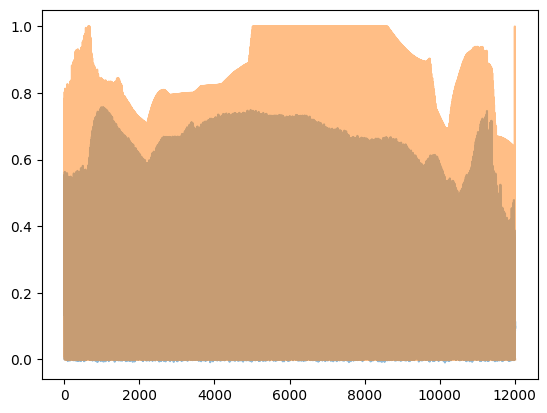

In [11]:
pred = reg.estimator(X)[0].detach().numpy()
plt.plot(pred[0], alpha=0.5)
plt.plot(X[0], alpha=0.5)

0.41533411568815215

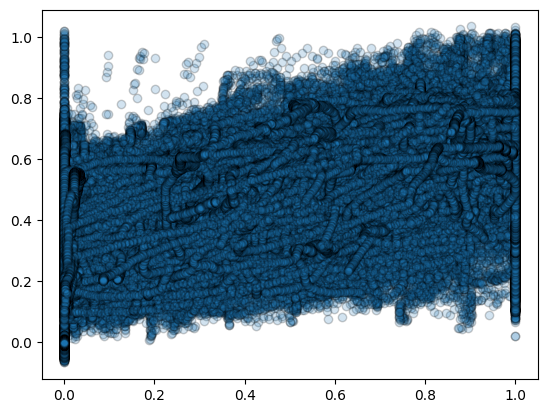

In [12]:
plt.scatter(X.reshape(-1, 1), pred.reshape(-1, 1), edgecolors='k', alpha=0.2)
from sklearn.metrics import r2_score
r2_score(X.reshape(-1, 1), pred.reshape(-1, 1))

In [13]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X_encoded[:, 0].min() - .5, X_encoded[:, 0].max() + .5
    y_min, y_max = X_encoded[:, 1].min() - .5, X_encoded[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=Y[:,0], cmap=plt.cm.Spectral)
    plt.show()


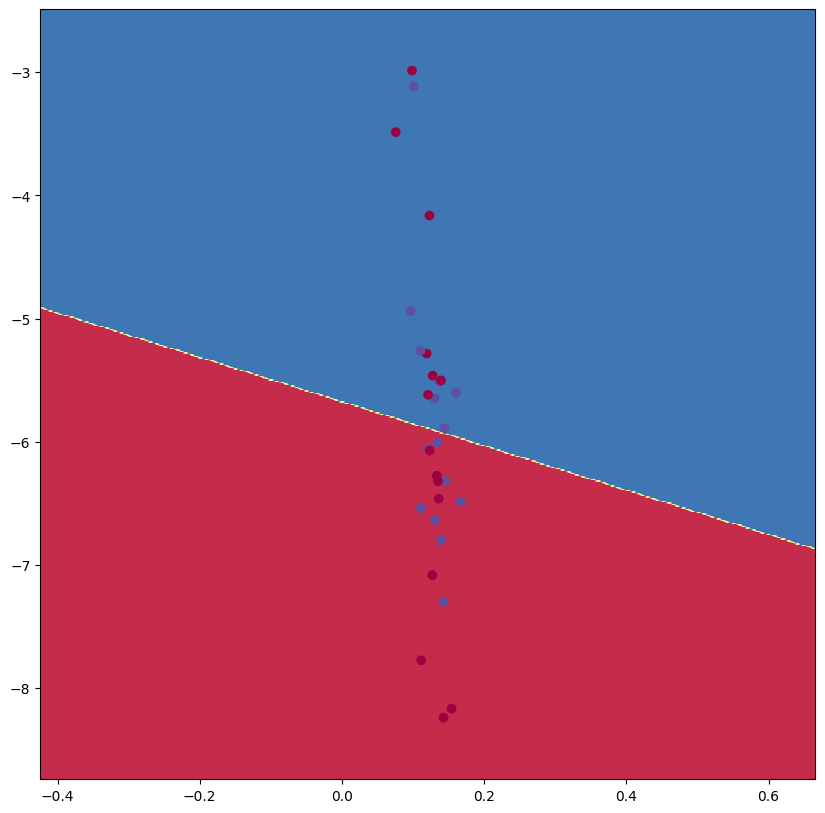

0.5

In [15]:
# use logistic regrssion to predict pain cohort from the latent space
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(random_state=0).fit(X_encoded, Y[:,0])

plot_decision_boundary(lambda x: reg.predict(x))
reg.score(X_encoded, Y[:,0])